In [1]:
from __future__ import division
import os
import sys

from glob import glob

import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

from psycopg2 import connect

In [2]:
pd.options.display.max_columns = 50

In [3]:
conn = connect(database='clinic', host='mypeg-71.igem.temple.edu', user='mypeg_lab_access', password='MegA26!')
cur = conn.cursor()

In [4]:
DF_HEADER = ['seq_pos','A','C','G','T','BLANK']

In [5]:
epFiles = sorted(glob('/DATA/raw/dbpshp/EP/*/*.txt'))
# print '\n'.join(epFiles)
print len(epFiles)

24046


In [6]:
rsids = pd.read_csv('/DATA/raw/dbpshp/coord-rsid_map.txt', sep='\t')

In [7]:
%%time
## First get all SNP positions EPs (usually 501 in each EP file w/ 500bp flanks)
dfs = []
for f in epFiles:
    chrom,posM1 = os.path.basename(f).split('.')[0].split('_')
    df = pd.read_csv(f, skiprows=1, header=None, names=DF_HEADER, usecols=range(5)).ix[[500]]
    df['chrom'] = chrom
    df['cpos_m1'] = int(posM1)
    
    dfs.append(df)

main = pd.concat(dfs).merge(rsids,on=['chrom','cpos_m1'])
del main['seq_pos']

CPU times: user 51.6 s, sys: 752 ms, total: 52.4 s
Wall time: 1min 13s


In [8]:
main.head()

,A,C,G,T,chrom,cpos_m1,rsid
0,0.023993,0.023966,0.928076,0.023966,chr10,101133998,rs4919305
1,0.012806,0.012806,0.961488,0.012899,chr10,101137062,rs3829211
2,0.019247,0.923048,0.019275,0.038430,chr10,102553994,rs1006544
3,0.016269,0.951127,0.016278,0.016325,chr10,102587573,rs12098288
4,0.035002,0.939107,0.012945,0.012945,chr10,102602125,rs2476973


In [9]:
## test query to get cols
query = "SELECT * FROM pop_data.all_2kg_snp_counts WHERE (chrom = 'chr10') AND (chrom_pos = 3058347)"
cur.execute(query)
res = cur.fetchone()
QUERY_COLS = [x[0] for x in cur.description]

In [10]:
def get_pop_data(row):
    query = "SELECT * FROM pop_data.all_2kg_snp_counts WHERE (chrom = '{}') AND (chrom_pos = {})".format(row['chrom'], row['cpos_m1'])
    cur.execute(query)
    if cur.rowcount == 0:
        return [np.nan,] * 9
    elif cur.rowcount == 1:
        res = dict(zip(QUERY_COLS, cur.fetchone()))
        
        ref_ep = row[res['ref']]
        alt_ep = row[res['alt']]
        
        if res['minor'] == res['ref']:
            ref_af = res['minor_cnt'] / res['total_cnt']
            alt_af = 1 - ref_af
        else:
            alt_af = res['minor_cnt'] / res['total_cnt']
            ref_af = 1 - alt_af
        
        ## get LoEP allele
        if ref_ep < alt_ep:
            lo_ep = ref_ep
            lo_af = ref_af
            lo_nuc = res['ref']
        elif alt_ep < ref_ep:
            lo_ep = alt_ep
            lo_af = alt_af
            lo_nuc = res['alt']
        else:
            lo_ep = alt_ep
            if ref_af > alt_af:
                lo_af = ref_af
                lo_nuc = res['ref']
            else:
                lo_af = alt_af
                lo_nuc = res['alt']            
    else:
        assert False
    
    return [res['ref'],ref_af,ref_ep,res['alt'],alt_af,alt_ep,lo_nuc,lo_af,lo_ep]

In [11]:
%%time
main['ref'],main['ref_af'],main['ref_ep'],main['alt'],main['alt_af'],main['alt_ep'],main['lo_nuc'],main['lo_af'],main['lo_ep'] = zip(*main.apply(get_pop_data, axis=1))

CPU times: user 3.63 s, sys: 340 ms, total: 3.97 s
Wall time: 23.6 s


In [12]:
focal = main[pd.notnull(main['ref'])]

In [38]:
focal.shape

(23833, 16)

In [39]:
focal.to_csv('/DATA/raw/dbpshp/dbpshp_ep.txt', sep='\t', index=False)

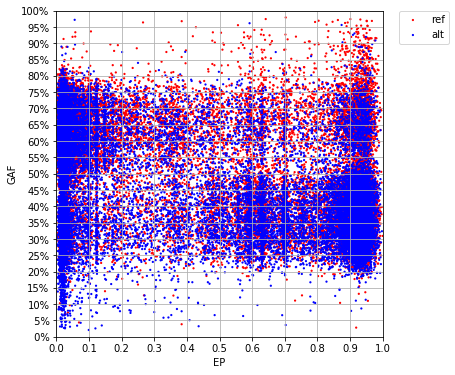

In [14]:
fig,ax = plt.subplots(1,1, figsize=(8,6), facecolor='#FFFFFF')

ax.scatter(focal['ref_ep'], focal['ref_af'], c='r', label='ref', s=5, edgecolors='none')
ax.scatter(focal['alt_ep'], focal['alt_af'], c='b', label='alt', s=5, edgecolors='none')

ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.set_xticks(np.linspace(0,1,11))
xticks = ax.get_xticks()
# ax.set_xticklabels(['{:2d}%'.format(int(x*100)) for x in xticks])

ax.set_yticks(np.linspace(0,1,21))
yticks = ax.get_yticks()
ax.set_yticklabels(['{:2d}%'.format(int(x*100)) for x in yticks])

ax.set_xlabel('EP')
ax.set_ylabel('GAF')

ax.set_aspect('equal')

ax.grid()

ax.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0)

In [15]:
epaf = []
for ix,row in focal.iterrows():
    epaf.append((row['ref_ep'],row['ref_af']))
    epaf.append((row['alt_ep'],row['alt_af']))
comb = pd.DataFrame(epaf, columns=['ep','af'])

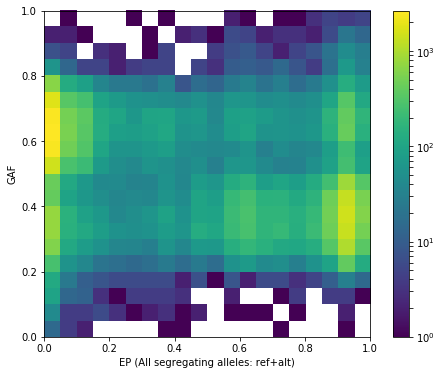

In [16]:
fig,ax = plt.subplots(1,1, figsize=(8,6), facecolor='#FFFFFF')

count,xedges,yedges,img = ax.hist2d(comb['ep'],comb['af'], norm=mpl.colors.LogNorm(), bins=(np.linspace(0,1,21),np.linspace(0,1,21)))

ax = plt.gca()

ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.set_xlabel('EP (All segregating alleles: ref+alt)')
ax.set_ylabel('GAF')

ax.set_aspect('equal')

plt.colorbar(img)

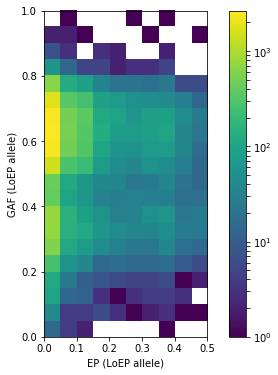

In [17]:
fig,ax = plt.subplots(1,1, figsize=(8,6), facecolor='#FFFFFF')

count,xedges,yedges,img = ax.hist2d(focal['lo_ep'],focal['lo_af'], norm=mpl.colors.LogNorm(), bins=(np.linspace(0,0.5,11),np.linspace(0,1,21)))

ax = plt.gca()

ax.set_xlim(0,0.5)
ax.set_ylim(0,1)

ax.set_xlabel('EP (LoEP allele)')
ax.set_ylabel('GAF (LoEP allele)')

ax.set_aspect('equal')

plt.colorbar(img)

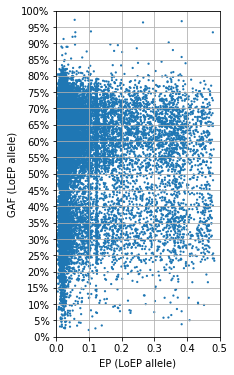

In [18]:
fig,ax = plt.subplots(1,1, figsize=(8,6), facecolor='#FFFFFF')

ax.scatter(focal['lo_ep'], focal['lo_af'], s=5, edgecolor='none')

ax.set_xlim(0,0.5)
ax.set_ylim(0,1)

ax.set_xticks(np.linspace(0,0.5,6))
xticks = ax.get_xticks()
# ax.set_xticklabels(['{:2d}%'.format(int(x*100)) for x in xticks])

ax.set_yticks(np.linspace(0,1,21))
yticks = ax.get_yticks()
ax.set_yticklabels(['{:2d}%'.format(int(x*100)) for x in yticks])

ax.set_xlabel('EP (LoEP allele)')
ax.set_ylabel('GAF (LoEP allele)')

ax.set_aspect('equal')

ax.grid()

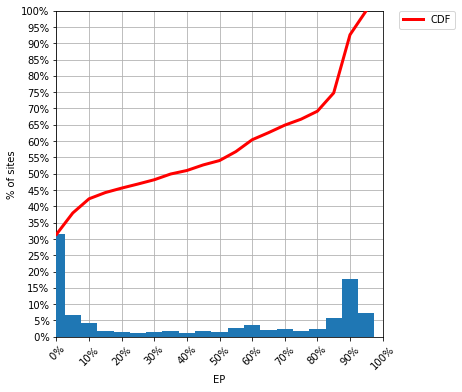

In [19]:
fig,ax = plt.subplots(1,1, figsize=(8,6), facecolor='#FFFFFF')

hist,bins = np.histogram(focal['ref_ep'], bins=np.linspace(0,1,21))
phist = hist/sum(hist)
chist = phist.cumsum()
ax.bar(bins[:-1], phist, width=bins[-1]-bins[-2], zorder=5)
ax.plot(bins[:-1], chist, linewidth=3, c='r', zorder=6, label='CDF')

ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.set_xticks(np.linspace(0,1,11))
xticks = ax.get_xticks()
ax.set_xticklabels(['{:2d}%'.format(int(x*100)) for x in xticks], rotation=45)

ax.set_yticks(np.linspace(0,1,21))
yticks = ax.get_yticks()
ax.set_yticklabels(['{:2d}%'.format(int(x*100)) for x in yticks])

ax.set_xlabel('EP')
ax.set_ylabel('% of sites')

ax.grid(zorder=0)

ax.set_aspect('equal')

ax.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0)

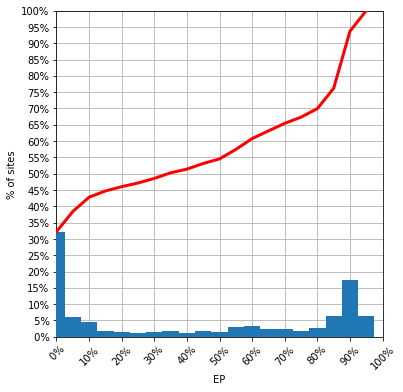

In [20]:
fig,ax = plt.subplots(1,1, figsize=(8,6), facecolor='#FFFFFF')

hist,bins = np.histogram(focal['alt_ep'], bins=np.linspace(0,1,21))
phist = hist/sum(hist)
chist = phist.cumsum()
ax.bar(bins[:-1], phist, width=bins[-1]-bins[-2], zorder=5)
ax.plot(bins[:-1], chist, linewidth=3, c='r', zorder=6)

ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.set_xticks(np.linspace(0,1,11))
xticks = ax.get_xticks()
ax.set_xticklabels(['{:2d}%'.format(int(x*100)) for x in xticks], rotation=45)

ax.set_yticks(np.linspace(0,1,21))
yticks = ax.get_yticks()
ax.set_yticklabels(['{:2d}%'.format(int(x*100)) for x in yticks])

ax.set_xlabel('EP')
ax.set_ylabel('% of sites')

ax.grid(zorder=0)

ax.set_aspect('equal')

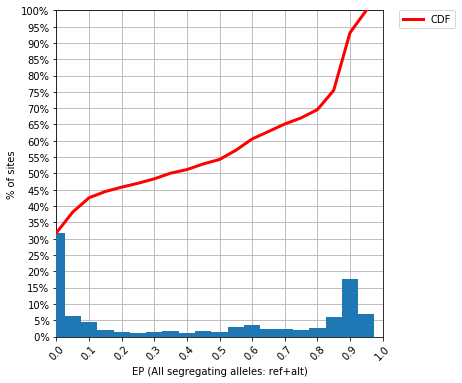

In [21]:
fig,ax = plt.subplots(1,1, figsize=(8,6), facecolor='#FFFFFF')

hist,bins = np.histogram(comb['ep'], bins=np.linspace(0,1,21))
phist = hist/sum(hist)
chist = phist.cumsum()
ax.bar(bins[:-1], phist, width=bins[-1]-bins[-2], zorder=5)
ax.plot(bins[:-1], chist, linewidth=3, c='r', zorder=6, label='CDF')

ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.set_xticks(np.linspace(0,1,11))
xticks = ax.get_xticks()
# ax.set_xticklabels(['{:2d}%'.format(int(x*100)) for x in xticks], rotation=45)
ax.set_xticklabels(xticks, rotation=45)

ax.set_yticks(np.linspace(0,1,21))
yticks = ax.get_yticks()
ax.set_yticklabels(['{:2d}%'.format(int(x*100)) for x in yticks])

ax.set_xlabel('EP (All segregating alleles: ref+alt)')
ax.set_ylabel('% of sites')

ax.grid(zorder=0)

ax.set_aspect('equal')

ax.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0)

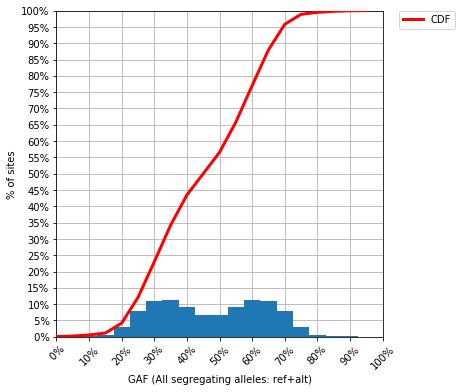

In [22]:
fig,ax = plt.subplots(1,1, figsize=(8,6), facecolor='#FFFFFF')

hist,bins = np.histogram(comb['af'], bins=np.linspace(0,1,21))
phist = hist/sum(hist)
chist = phist.cumsum()
ax.bar(bins[:-1], phist, width=bins[-1]-bins[-2], zorder=5)
ax.plot(bins[:-1], chist, linewidth=3, c='r', zorder=6, label='CDF')

ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.set_xticks(np.linspace(0,1,11))
xticks = ax.get_xticks()
ax.set_xticklabels(['{:2d}%'.format(int(x*100)) for x in xticks], rotation=45)

ax.set_yticks(np.linspace(0,1,21))
yticks = ax.get_yticks()
ax.set_yticklabels(['{:2d}%'.format(int(x*100)) for x in yticks])

ax.set_xlabel('GAF (All segregating alleles: ref+alt)')
ax.set_ylabel('% of sites')

ax.grid(zorder=0)

ax.set_aspect('equal')

ax.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0)

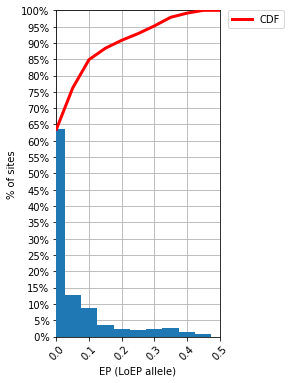

In [23]:
fig,ax = plt.subplots(1,1, figsize=(8,6), facecolor='#FFFFFF')

hist,bins = np.histogram(focal['lo_ep'], bins=np.linspace(0,1,21))
phist = hist/sum(hist)
chist = phist.cumsum()
ax.bar(bins[:-1], phist, width=bins[-1]-bins[-2], zorder=5)
ax.plot(bins[:-1], chist, linewidth=3, c='r', zorder=6, label='CDF')

ax.set_xlim(0,0.5)
ax.set_ylim(0,1)

ax.set_xticks(np.linspace(0,0.5,6))
xticks = ax.get_xticks()
# ax.set_xticklabels(['{:2d}%'.format(int(x*100)) for x in xticks], rotation=45)
ax.set_xticklabels(xticks, rotation=45)

ax.set_yticks(np.linspace(0,1,21))
yticks = ax.get_yticks()
ax.set_yticklabels(['{:2d}%'.format(int(x*100)) for x in yticks])

ax.set_xlabel('EP (LoEP allele)')
ax.set_ylabel('% of sites')

ax.grid(zorder=0)

ax.set_aspect('equal')

ax.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0)

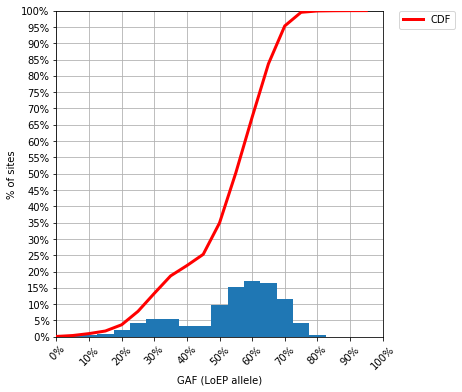

In [24]:
fig,ax = plt.subplots(1,1, figsize=(8,6), facecolor='#FFFFFF')

hist,bins = np.histogram(focal['lo_af'], bins=np.linspace(0,1,21))
phist = hist/sum(hist)
chist = phist.cumsum()
ax.bar(bins[:-1], phist, width=bins[-1]-bins[-2], zorder=5)
ax.plot(bins[:-1], chist, linewidth=3, c='r', zorder=6, label='CDF')

ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.set_xticks(np.linspace(0,1,11))
xticks = ax.get_xticks()
ax.set_xticklabels(['{:2d}%'.format(int(x*100)) for x in xticks], rotation=45)

ax.set_yticks(np.linspace(0,1,21))
yticks = ax.get_yticks()
ax.set_yticklabels(['{:2d}%'.format(int(x*100)) for x in yticks])

ax.set_xlabel('GAF (LoEP allele)')
ax.set_ylabel('% of sites')

ax.grid(zorder=0)

ax.set_aspect('equal')

ax.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0)

In [25]:
gwas = pd.read_csv('/DATA/raw/dbpshp/gwas_best.txt', sep='\t')
print gwas.shape

(20667, 13)


In [26]:
gwas['cpos_m1'] = gwas['chrom_pos']-1

In [27]:
dbpshp = pd.merge(focal, gwas, on=['chrom','cpos_m1'], how='outer')

In [28]:
dbpshp.shape

(24020, 28)

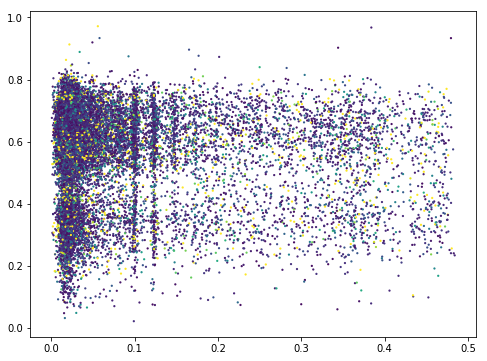

In [36]:
fig,ax = plt.subplots(1,1, figsize=(8,6), facecolor='#FFFFFF')

tmp = dbpshp[pd.notnull(dbpshp['lo_ep']) & pd.notnull(dbpshp['neg_log10_p'])]
ax.scatter(tmp['lo_ep'], tmp['lo_af'], c=tmp['neg_log10_p'], edgecolor='none', s=5, vmin=1, vmax=10)


In [37]:
tmp

,A,C,G,T,chrom,cpos_m1,rsid,ref,ref_af,ref_ep,alt,alt_af,alt_ep,lo_nuc,lo_af,lo_ep,chrom_pos,snpid_in_dbsnp,snpid_in_paper,pmid,pvalue,phenotype,paper_phenotype_description,paper_phenotype_categories,title,in_gene,dbsnp_fx,neg_log10_p
0,0.023993,0.023966,0.928076,0.023966,chr10,101133998,rs4919305,T,0.616214,0.023966,G,0.383786,0.928076,T,0.616214,0.023966,101133999.0,4919305.0,rs4919305,20502693,7.770000e-06,Gene expression of ZNF639 in peripheral blood ...,Gene expression in monocytes,Quantitative trait(s);Gene expression (RNA);Bl...,Genetics and beyond--the transcriptome of huma...,(CNNM1),Intron,5.109579
1,0.012806,0.012806,0.961488,0.012899,chr10,101137062,rs3829211,G,0.529553,0.961488,A,0.470447,0.012806,A,0.470447,0.012806,101137063.0,3829211.0,rs3829211,20686565,1.138000e-02,Triglycerides,Lipid level measurements,CVD risk factor (CVD RF);Lipids,"Biological, clinical and population relevance ...",(CNNM1),Intron,1.943858
2,0.019247,0.923048,0.019275,0.038430,chr10,102553994,rs1006544,C,0.400958,0.923048,T,0.599042,0.038430,T,0.599042,0.038430,102553995.0,1006544.0,rs1006544,22182935,3.343000e-02,Bipolar disorder,Bipolar disorder,Neuro;Behavioral;Bipolar disorder,Genome-wide association study meta-analysis of...,(PAX2),Intron,1.475864
4,0.035002,0.939107,0.012945,0.012945,chr10,102602125,rs2476973,A,0.681510,0.035002,C,0.318490,0.939107,A,0.681510,0.035002,102602126.0,2476973.0,rs2476973,23455636,2.482700e-02,Advanced age-related macular degeneration (geo...,Age-related macular degeneration,Eye-related;Aging;Age-related macular degenera...,Seven new loci associated with age-related mac...,NaN,NaN,1.605076
5,0.033311,0.480437,0.033255,0.452998,chr10,103340448,rs3095795,T,0.784345,0.452998,C,0.215655,0.480437,T,0.784345,0.452998,103340449.0,3095795.0,rs3095795,19060906,2.239000e-04,Triglycerides,Lipid level measurements,CVD risk factor (CVD RF);Lipids,Common variants at 30 loci contribute to polyg...,(POLL),Intron,3.649946
6,0.011998,0.011998,0.964005,0.011998,chr10,103340917,rs1549067,A,0.784345,0.011998,G,0.215655,0.964005,A,0.784345,0.011998,103340918.0,1549067.0,rs1549067,19060906,3.193000e-04,Triglycerides,Lipid level measurements,CVD risk factor (CVD RF);Lipids,Common variants at 30 loci contribute to polyg...,(POLL),Intron,3.495801
9,0.970200,0.009933,0.009933,0.009933,chr10,106549899,rs1490171,A,0.314696,0.970200,G,0.685304,0.009933,G,0.685304,0.009933,106549900.0,1490171.0,rs1490171,18587394,3.290002e-03,Irritible bowel syndrome,Crohn's disease,Inflammation;Gastrointestinal;Crohn's disease,Genome-wide association defines more than 30 d...,(SORCS3),Intron,2.482804
10,0.381287,0.027560,0.542652,0.048501,chr10,106620896,rs10884058,G,0.536941,0.542652,A,0.463059,0.381287,A,0.463059,0.381287,106620897.0,10884058.0,rs10884058,22451204,1.221000e-02,Parkinson's disease,Parkinson's disease,Neuro;Parkinson's disease,Meta-analysis of Parkinson's disease: identifi...,(SORCS3),Intron,1.913284
11,0.021142,0.936566,0.021142,0.021149,chr10,106622145,rs11192210,C,0.537939,0.936566,T,0.462061,0.021149,T,0.462061,0.021149,106622146.0,11192210.0,rs11192210,22451204,1.216000e-02,Parkinson's disease,Parkinson's disease,Neuro;Parkinson's disease,Meta-analysis of Parkinson's disease: identifi...,(SORCS3),Intron,1.915066
12,0.017997,0.939555,0.022932,0.019517,chr10,106623377,rs11192212,C,0.538139,0.939555,T,0.461861,0.019517,T,0.461861,0.019517,106623378.0,11192212.0,rs11192212,21283786,1.220000e-05,Gene expression of SORCS3 [probe ILMN_13257] i...,Gene expression in treated osteoblasts,Quantitative trait(s);Gene expression (RNA);Bo...,Global analysis of the impact of environmental...,(SORCS3),Intron,4.913640


In [30]:
best = dbpshp.sort_values(by=['neg_log10_p', 'lo_ep'], ascending=[False,True])

In [31]:
best

,A,C,G,T,chrom,cpos_m1,rsid,ref,ref_af,ref_ep,alt,alt_af,alt_ep,lo_nuc,lo_af,lo_ep,chrom_pos,snpid_in_dbsnp,snpid_in_paper,pmid,pvalue,phenotype,paper_phenotype_description,paper_phenotype_categories,title,in_gene,dbsnp_fx,neg_log10_p
4148,0.971403,0.009532,0.009532,0.009532,chr15,28365617,rs12913832,A,0.822684,0.971403,G,0.177316,0.009532,G,0.177316,0.009532,28365618.0,12913832.0,rs12913832,21926416,0.000000e+00,Eye color (blue versus brown),Skin cancer (cutaneous melanoma),Cancer;Skin cancer;Skin-related;Melanoma,Genome-wide association study identifies novel...,(HERC2),Intron,522.114639
18038,0.026264,0.630525,0.025715,0.317496,chr5,81585736,rs862245,C,0.239816,0.630525,A,0.760184,0.026264,A,0.760184,0.026264,81585737.0,862245.0,rs862245,20502693,4.940656e-324,Gene expression of RPS23 in peripheral blood m...,Gene expression in monocytes,Quantitative trait(s);Gene expression (RNA);Bl...,Genetics and beyond--the transcriptome of huma...,NaN,NaN,323.301030
10377,0.475677,0.016471,0.491381,0.016471,chr2,17845295,rs2710673,A,0.364617,0.475677,G,0.635383,0.491381,A,0.364617,0.475677,17845296.0,2710673.0,rs2710673,20502693,4.940656e-324,Gene expression of SMC6 in peripheral blood mo...,Gene expression in monocytes,Quantitative trait(s);Gene expression (RNA);Bl...,Genetics and beyond--the transcriptome of huma...,(SMC6),3'UTR,323.301030
7061,0.956334,0.014555,0.014555,0.014555,chr1,196654323,rs1061147,A,0.286941,0.956334,C,0.713059,0.014555,C,0.713059,0.014555,196654324.0,1061147.0,rs1061147,23455636,1.173700e-286,Advanced age-related macular degeneration,Age-related macular degeneration,Eye-related;Aging;Age-related macular degenera...,Seven new loci associated with age-related mac...,(CFH),Synonymous,285.930443
7063,0.951135,0.016258,0.016348,0.016258,chr1,196656204,rs1329421,A,0.286941,0.951135,T,0.713059,0.016258,T,0.713059,0.016258,196656205.0,1329421.0,rs1329421,23455636,3.490800e-286,Advanced age-related macular degeneration,Age-related macular degeneration,Eye-related;Aging;Age-related macular degenera...,Seven new loci associated with age-related mac...,(CFH),Intron,285.457075
7062,0.929063,0.023646,0.023646,0.023646,chr1,196655742,rs10801553,A,0.264177,0.929063,C,0.735823,0.023646,C,0.735823,0.023646,196655743.0,10801553.0,rs10801553,23455636,4.063300e-286,Advanced age-related macular degeneration,Age-related macular degeneration,Eye-related;Aging;Age-related macular degenera...,Seven new loci associated with age-related mac...,(CFH),Intron,285.391121
19159,0.012995,0.012995,0.012995,0.961015,chr6,42915919,rs6941212,T,0.657548,0.961015,C,0.342452,0.012995,C,0.342452,0.012995,42915920.0,6941212.0,rs6941212,20502693,2.450000e-279,Gene expression of PEX6 in peripheral blood mo...,Gene expression in monocytes,Quantitative trait(s);Gene expression (RNA);Bl...,Genetics and beyond--the transcriptome of huma...,NaN,NaN,278.610834
2176,0.025213,0.025264,0.025222,0.924301,chr12,131280713,rs10848205,T,0.460064,0.924301,C,0.539936,0.025264,C,0.539936,0.025264,131280714.0,10848205.0,rs10848205,20502693,3.860000e-274,Gene expression of STX2 in peripheral blood mo...,Gene expression in monocytes,Quantitative trait(s);Gene expression (RNA);Bl...,Genetics and beyond--the transcriptome of huma...,(STX2),Intron,273.413413
10406,0.050796,0.135019,0.786394,0.027792,chr2,17958761,rs2615048,G,0.594249,0.786394,A,0.405751,0.050796,A,0.405751,0.050796,17958762.0,2615048.0,rs2615048,20502693,1.060000e-269,Gene expression of SMC6 in peripheral blood mo...,Gene expression in monocytes,Quantitative trait(s);Gene expression (RNA);Bl...,Genetics and beyond--the transcriptome of huma...,(GEN1),Intron,268.974694
1579,0.006026,0.981922,0.006026,0.006026,chr11,61551355,rs174535,T,0.659944,0.006026,C,0.340056,0.981922,T,0.659944,0.006026,61551356.0,174535.0,rs174535,22286219,3.660000e-265,Serum LA/PUFA,"Metabolites, in serum",Quantitative trait(s);Blood-related;Serum,Genome-wide association study identifies multi...,(C11orf9),Synonymous,264.436519
